# Feature Store Pipeline
This script prepares all elements of the feature store: 
- One-hot-encoding of each genre into a binary flag
- Doc2Vec - fit and transform to generate 100-D embeddings
- Pivotting to create 'long-form' suitable for matrix-style cross calculations in Tableau

In [6]:
import pandas as pd
import numpy as np
import os
import json

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import STOPWORDS 
from gensim.utils import simple_preprocess

from nltk.stem.lancaster import LancasterStemmer

# define function to perform one-hot encoding (a column flag for each genre) and pivot data
def create_genre_flags(df, col_list, id_vars=['movieID']):
    print('Encoding the following genres: '+', '.join(col_list))
    output=df.copy()
    for each in col_list:
        output[each]=output.genres_raw.apply(lambda x: 1 if each in x else 0)
    return output

def preprocessor_and_stem(text, my_stop_words):
    """uses gensim simple_preprocess and then removes stop words
    -> used in the tag_docs function
    """
    # Instantiate a LancasterStemmer object, use gensim simple_preprocess to tokenize/lowercase
    # and then removes stop words
    ls = LancasterStemmer()
    simple = simple_preprocess(text)
    result = [ls.stem(word) for word in simple if not word in my_stop_words]
    return result

def stem_tag_docs(docs, my_stop_words, id_col='id', text_col='text'):
    results = docs.apply(lambda r: TaggedDocument(words=preprocessor_and_stem(r[text_col], my_stop_words), tags=[str(r[id_col])]), axis=1)
    return results.tolist()

def categorise_attribute(variable, genres):
    if variable in ['tsne_x', 'tsne_y']:
        return 'tsne_doc2vec'
    elif variable in genres:
        return 'genre'
    elif isinstance(variable, str):
        return 'other'
    elif isinstance(variable, int):
        return 'doc2vec'


my_stop_words = STOPWORDS

In [2]:
#Load in configs and dependencies
#baseDir=pathlib.Path(__file__).parent.resolve()
baseDir=os.getcwd()
parentDir=os.path.dirname(baseDir)
configLocation=os.path.join(baseDir, "config.json")
with open(configLocation, "r") as f:
    configs = json.load(f)

datafolder=os.path.join(parentDir,configs["inputfolder"])
outputfolder=os.path.join(parentDir,configs["outputfolder"])
tempfolder = os.path.join(parentDir,configs["tempfolder"])


Let's compare how well the movie genres cluster based on the Doc2Vec of their descriptions either with or without the genre list concatenated...

### Genre one-hot encoding

In [3]:
movieData=pd.read_csv(f'{tempfolder}/movie_fact.csv',usecols=['movieID', 'description', 'genres_raw', 'release_year'])
movieData.description=movieData.description.astype(str)
movieData['description_genre']=movieData.description+' '+movieData.genres_raw
movieData.description_genre=movieData.description_genre.astype(str)

# create one-hot flag per genre and pivot the data (wide to long)
genres=list(set(np.concatenate(movieData.genres_raw.str.split(', '))))
movieData=create_genre_flags(movieData, genres)

movieData.info()

Encoding the following genres: Drama, Action, War, Fantasy, Children, Thriller, Documentary, Musical, Horror, IMAX, Film-Noir, Romance, (no genres listed), Western, Crime, Mystery, Sci-Fi, Adventure, Animation, Comedy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   release_year        9742 non-null   int64 
 1   genres_raw          9742 non-null   object
 2   description         9742 non-null   object
 3   movieID             9742 non-null   object
 4   description_genre   9742 non-null   object
 5   Drama               9742 non-null   int64 
 6   Action              9742 non-null   int64 
 7   War                 9742 non-null   int64 
 8   Fantasy             9742 non-null   int64 
 9   Children            9742 non-null   int64 
 10  Thriller            9742 non-null   int64 
 11  Documentary         9742 non-null   int64 
 12

### Doc2Vec

- Use the Doc2Vec generated including genre in text, as this shows improved clustering per genre which will likely assist with similarity scoring (as the whole paragraph contributes rather than individual words, this is not directly replicating the one-hot-encoded genre flag features)
- When generating Doc2Vec, exclude records with no description - these create a clustered region which is external to the main body of values due to only including the genres. These do not overlap with the primary clusters seen per genre.
- For records with no description, use the average per Doc2Vec dimension - we can't assume 0 is in the middle for every dimension, so doing this should mean we are prioritising the genre/year features when trying to compare these examples. 

In [4]:
from gensim.utils import simple_preprocess

# filter out any cases where description is null before removing stopwords and stemming
tagged_stem_docs_genre = stem_tag_docs(movieData[movieData.description!='nan'][['movieID', 'description_genre']], my_stop_words,  id_col='movieID', text_col='description_genre')

# Instantiate a Doc2Vec model, and build the vocab from the tagged documents
model_genre = Doc2Vec(dm=0, dbow_words=1, min_count=4)
model_genre.build_vocab(tagged_stem_docs_genre, progress_per = 100)
model_genre.train(tagged_stem_docs_genre, total_examples=model_genre.corpus_count, epochs=10)

#
doc_tags = list(model_genre.dv.key_to_index.keys())
X_genre = model_genre[doc_tags]



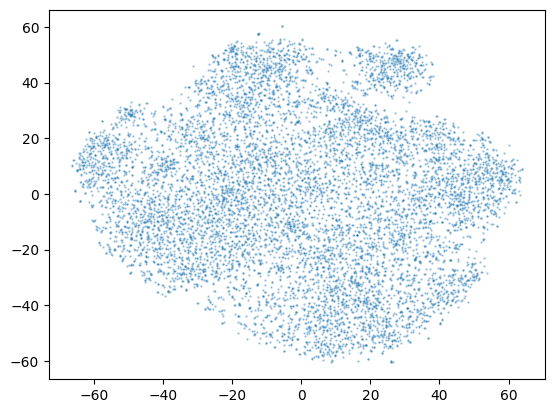

In [47]:
# generate tsne components, include mean record for all the nulls
tsne_genre = TSNE(n_components=2)
X_tsne_genre = tsne_genre.fit_transform(np.vstack([X_genre, X_genre.mean(axis=0)]))
df_genre = pd.DataFrame(X_tsne_genre[:-1], index = doc_tags,columns=['tsne_x', 'tsne_y'])
plt.scatter(df_genre['tsne_x'], df_genre['tsne_y'], s=0.4, alpha=0.4)


In [56]:


# Make DF with records which have empty description (nan due to string cast performed on load). Fill Doc2Vec features with mean
null_docs = movieData[movieData.description=='nan'].movieID
null_df = pd.concat([movieData[movieData.description=='nan'].drop(columns=['genres_raw', 'description', 'description_genre']).set_index('movieID'), pd.DataFrame(np.tile(X_genre.mean(axis=0), (len(movieData[movieData.description=='nan']), 1)), index=null_docs), pd.DataFrame(np.tile(X_tsne_genre[-1], (len(movieData[movieData.description=='nan']), 1)), index=null_docs, columns=['tsne_x', 'tsne_y'])], axis=1)

#make DF with all valid records (description is populated)
d2v_df=pd.concat([movieData[movieData.description!='nan'].drop(columns=['genres_raw', 'description', 'description_genre']).set_index('movieID'), pd.DataFrame(X_genre, index=doc_tags), df_genre], axis=1)

#combine into one
d2v_df=pd.concat([d2v_df, null_df], axis=0).reset_index(names='movieID')

feature_df=pd.melt(d2v_df, id_vars=['movieID'])
feature_df['attribute_type']= feature_df.variable.apply(lambda x: categorise_attribute(x, genres))
feature_df.tail()

,movieID,variable,value,attribute_type
1198261,M_179135,tsne_y,1.389808,tsne_doc2vec
1198262,M_180263,tsne_y,1.389808,tsne_doc2vec
1198263,M_180777,tsne_y,1.389808,tsne_doc2vec
1198264,M_184257,tsne_y,1.389808,tsne_doc2vec
1198265,M_185135,tsne_y,1.389808,tsne_doc2vec


### Save

In [55]:
feature_df.to_csv(f'{outputfolder}/movie_feature_store.csv', index=False)

In [59]:
movieFact=pd.read_csv(f'{tempfolder}/movie_fact.csv')
# Add tsne to movie Fact so that we don't need secondary axis
movieFact = movieFact.merge(d2v_df[['movieID', 'tsne_x', 'tsne_y']], on='movieID')
movieFact.to_csv(f'{outputfolder}/movie_fact.csv', index=False)